In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, \
plot_roc_curve, confusion_matrix, roc_auc_score, RocCurveDisplay, auc, roc_curve

%pylab inline

import warnings
warnings.filterwarnings('ignore')


SEED = 42

Populating the interactive namespace from numpy and matplotlib


### Логистическая регрессия с L2 регуляризацией
Вспомним как выглядит логистическая функция потерь:
$$J(w)=\sum_i^n(-y_ilog(a(x_i))-(1-y_i)log(1-a(x_i)))$$
L2-регуляризация - это дополнительное слагаемое в функции потерь, которое штрафует в процессе обучения высокие значения весов w: $$\lambda |w|^2$$
В случае логистической регрессии используется следующий коэффициент регуляризации: $$C=\frac{1}{\lambda}$$
Тогда решение задачи минимизации функции потерь будет выглядеть следующим образом:
$$w=argmin_wJ(w)=argmin_w(C\sum_i^n(-y_ilog(a(x_i))-(1-y_i)log(1-a(x_i)))+|w|^2)$$

Посмотрим как влияет регуляризация на качество классификации.
В задаче будем использовать логистическую регрессию с полиномиальными признаками.
[Источник](https://habr.com/ru/company/ods/blog/323890/#2-logisticheskaya-regressiya), откуда взят пример.

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

В качестве датасета возьмем данные по тестированию микрочипов из курса Эндрю Ына.
В датасете указаны результаты двух тестов микрочипов test1 и test2 и результат выпуска в производство released.

In [3]:
data = pd.read_csv('input/microchip_tests.txt',header=None, names = ('test1','test2','released'))
data.head()

,test1,test2,released
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   test1     118 non-null    float64
 1   test2     118 non-null    float64
 2   released  118 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.9 KB


Отобразим признаки и раскрасим их в цвета таргета. Красный - бракованный, зеленый - нормальный чип.

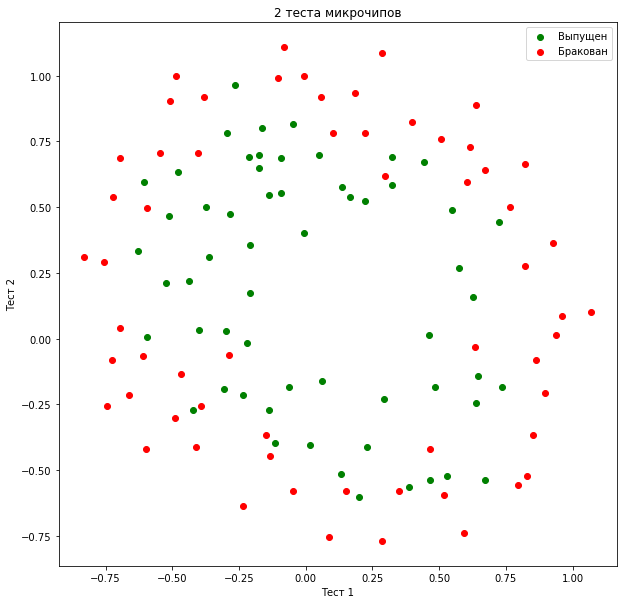

In [5]:
X = data.iloc[:,:2].values
y = data.iloc[:,2].values

plt.figure(figsize=(10,10))
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов')
plt.legend();

Функция для отображения разделяющей кривой

In [6]:
def plot_boundary(clf, X, y, grid_step=.01, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step), np.arange(y_min, y_max, grid_step))

    # каждой точке в сетке [x_min, m_max]x[y_min, y_max]
    # ставим в соответствие свой цвет
    Z = clf.predict(poly_featurizer.transform(np.vstack([xx.ravel(), yy.ravel()]).transpose()))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap='Paired')

Пример полиномиальных признаков степени d=2:
$$1,x_1,x_2,x_1^2,x_2^2,x_1x_2$$

In [7]:
# Создадим полиномиальные признаки до 7 степени
poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X)

Обучим логистическую регрессию на полиномиальных признаках с коээфициентом регуляризации C=0.01 

Доля правильных ответов классификатора на обучающей выборке: 0.627


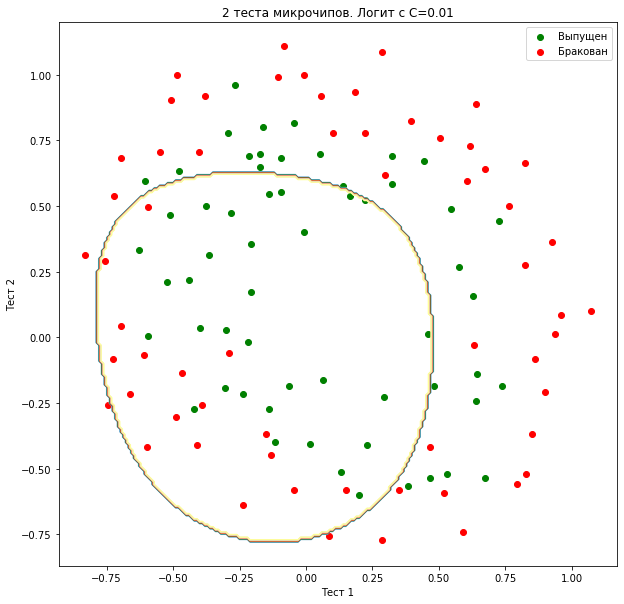

In [8]:
C = 1e-2
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_poly, y)

plt.figure(figsize=(10,10))
plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов. Логит с C=0.01')
plt.legend();

print("Доля правильных ответов классификатора на обучающей выборке:", 
round(logit.score(X_poly, y), 3))

Регуляризация оказалась слишком сильной, модель недообучилась. Посмотрим на веса регрессии:

In [9]:
np.abs(logit.coef_).max()

0.05512701059402994

Доля правильных ответов классификатора на обучающей выборке: 0.831


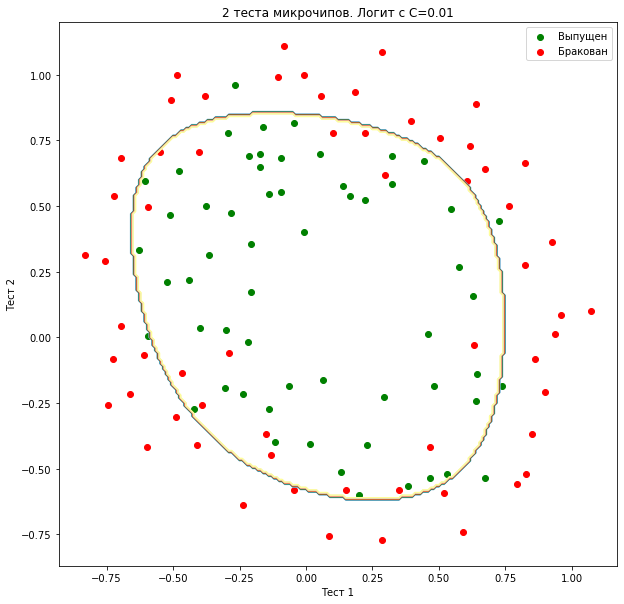

In [10]:
C = 1
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_poly, y)

plt.figure(figsize=(10,10))
plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов. Логит с C=0.01')
plt.legend();

print("Доля правильных ответов классификатора на обучающей выборке:", 
round(logit.score(X_poly, y), 3))

Ослабив регуляризацию (С=1) получим более качественный прогноз, при этом абсолютные значения весов возрастут:

In [11]:
np.abs(logit.coef_).max()

2.0063370535362

Увеличив С до 10000 мы тем самым еще сильнее ослабим регуляризацию.

Доля правильных ответов классификатора на обучающей выборке: 0.873


/home/bulat/anaconda3/envs/ugatu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


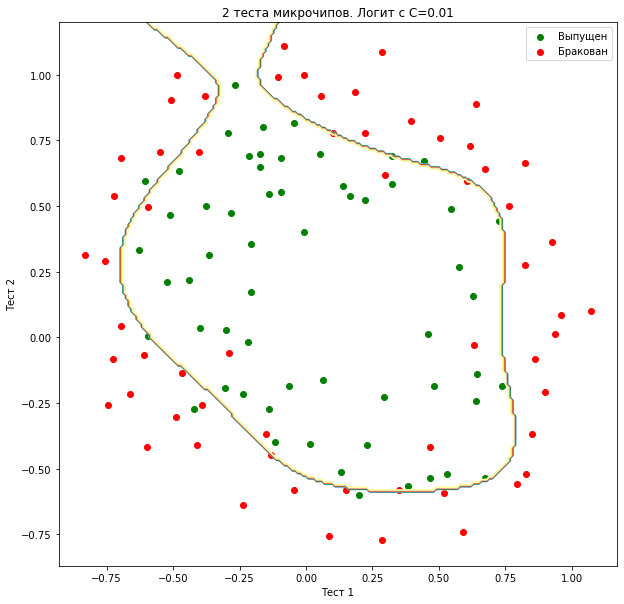

In [12]:
C = 1e4
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_poly, y)

plt.figure(figsize=(10,10))
plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('2 теста микрочипов. Логит с C=0.01')
plt.legend();

print("Доля правильных ответов классификатора на обучающей выборке:", 
round(logit.score(X_poly, y), 3))

Видим, что модель переобучилась. Разделяющая плоскость имеет сложную нелинейную форму, веса выросли. При этом доля верных ответов существенно не изменилась.

In [13]:
np.abs(logit.coef_).max()

27.733468825074574

#### Выводы

- Чем больше С, тем более сложные зависимости могут восстанавливаться, но при этом веса становятся огромными что может привести к большим ошибкам на отложенной выборке. Другими словами модель переобучается.
- При этом малые значения С (сильная регуляризация) может привести к занулению весов, то есть некоторые признаки перестанут влиять на прогноз. Модель в таком случае недообучается.
- Величина С - гиперпараметр, который необходимо подбирать на кросс-валидации.

## Рассмотрим работу Логистической регрессии на примере датасета Титаник

In [14]:
train = pd.read_csv('input/titanic_train.csv')
test = pd.read_csv('input/titanic_test.csv')

train.shape, test.shape

((891, 12), (418, 11))

In [15]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Разделим признаки по типам

In [16]:
# Прогнозируемая величина
target = 'Survived'

# Категориальные 
cat_feats = [
    'Pclass',
    'Embarked',
    'Sex'
]

# Вещественные
num_feats = [
    'Age',
    'SibSp',
    'Parch',
    'Fare'
]

#### Применим One-hot encoding для кодирования категориальных переменных

In [17]:
# Encode cats
cat_df = pd.get_dummies(train[cat_feats])

# Get new df
train_new = pd.concat([train[num_feats], cat_df], axis=1)
train_new.shape

(891, 10)

In [18]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         714 non-null    float64
 1   SibSp       891 non-null    int64  
 2   Parch       891 non-null    int64  
 3   Fare        891 non-null    float64
 4   Pclass      891 non-null    int64  
 5   Embarked_C  891 non-null    uint8  
 6   Embarked_Q  891 non-null    uint8  
 7   Embarked_S  891 non-null    uint8  
 8   Sex_female  891 non-null    uint8  
 9   Sex_male    891 non-null    uint8  
dtypes: float64(2), int64(3), uint8(5)
memory usage: 39.3 KB


In [19]:
# Заполним пропуски по возрасту медианными значениями
train_new['Age'] = train_new['Age'].fillna(train_new['Age'].median())
train_new.isnull().sum().sum()

0

In [20]:
# Разделим выборку на обучающую и валидационную
X_train, X_valid, y_train, y_valid = train_test_split(
     train_new, train[target], test_size=0.2, random_state=42)
X_train.shape, X_valid.shape

((712, 10), (179, 10))

In [21]:
# Применим масштабирование к вещественным признакам  
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[num_feats])
X_valid_num = scaler.transform(X_valid[num_feats])

X_train_final = np.hstack([X_train_num, X_train.drop(num_feats, axis=1).values])
X_valid_final = np.hstack([X_valid_num, X_valid.drop(num_feats, axis=1).values])
X_train_final.shape, X_valid_final.shape

((712, 10), (179, 10))

#### Обучим модель и протестируем ее на отложенной выборке

In [22]:
# Инициализация объекта модели
lr = LogisticRegression()
# Обучение
lr.fit(X_train_final, y_train)
# Предсказание
y_pred = lr.predict(X_valid_final)
# Расчет метрики ROC-AUC
roc_auc_score(y_valid, y_pred)

0.8001930501930502

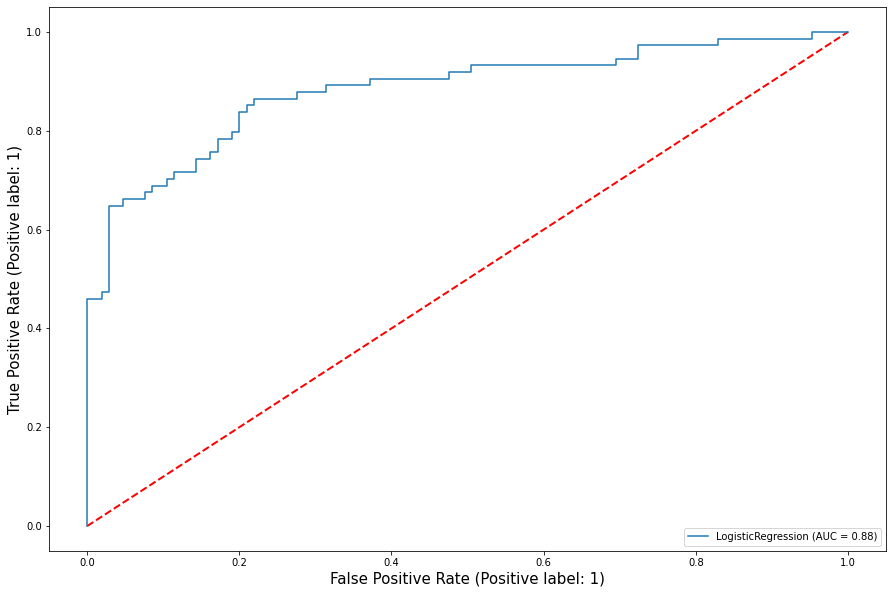

In [23]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), linestyle='--', lw=2, color='r')
RocCurveDisplay.from_estimator(lr, X_valid_final, y_valid, ax=ax)
#plt.legend(['RandompPredict (AUC=0.5)', 'LogisticRegression (AUC=0.88)'])
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)

plt.show();

AUC на графике больше значения метрики roc_auc_score, поскольку график построен только для положительных лейблов, а метрика усредняется по классам.

### Подбор параметров с помощью GridSearshCV

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

In [25]:
#создаем pipeline из двух шагов: scaling и классификация
pipeline = Pipeline(steps = [('scaling', scaler), ('logregression', lr)])

In [26]:
parameters_grid = {
    #'logregression__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logregression__C' : np.linspace(0,1, 100), 
    #'logregression__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    #'scaling__with_mean' : [0., 0.5],
}

In [31]:
scoring = {"AUC": "roc_auc", "Accuracy": 'accuracy'}

grid_cv = GridSearchCV(pipeline, 
                       parameters_grid, 
                       scoring = scoring, 
                       cv = 4,
                       refit="AUC",
                       return_train_score=True,
                      )

In [32]:
%%time
grid_cv.fit(X_train, y_train);
results = grid_cv.cv_results_

CPU times: user 32.5 s, sys: 279 ms, total: 32.7 s
Wall time: 4.1 s


In [33]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.8443424768051633
{'logregression__C': 0.22222222222222224}


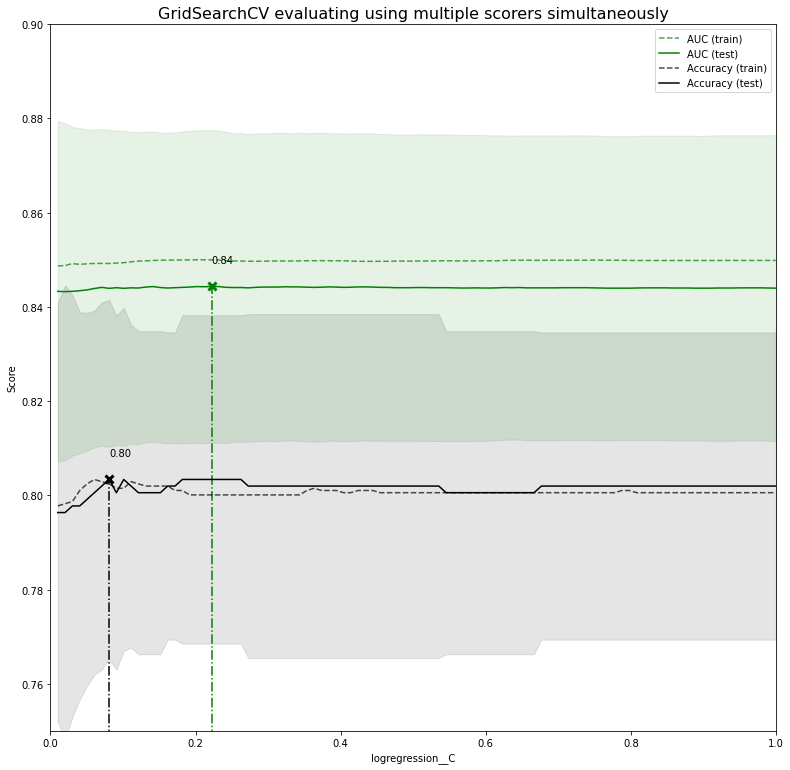

In [34]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("logregression__C")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 1)
ax.set_ylim(0.75, 0.9)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["param_logregression__C"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()